#第8章: ニューラルネット

【注】 https://nlp100.github.io/ja/ch08.html　(ノートーブックでは数式などのフォーマットが崩れているので、このURL先の課題を見てください。)

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##準備
ファイルIOするので、GDriveをマウントして、適当なフォルダーにカレントディレクトリーを設定する

最初はGPUなしで実行してください。あとで、GPUアリの効果を見るため。

In [6]:
!pwd
%cd /content/drive/MyDrive/Colab Notebooks/NLP

/content/drive/My Drive/Colab Notebooks/NLP
/content/drive/MyDrive/Colab Notebooks/NLP


##課題70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Y

を作成したい．
X=⎛⎝⎜⎜⎜x1x2…xn⎞⎠⎟⎟⎟∈Rn×d,Y=⎛⎝⎜⎜⎜y1y2…yn⎞⎠⎟⎟⎟∈Nn

ここで，n
は学習データの事例数であり，xi∈Rdとyi∈Nはそれぞれ，i∈{1,…,n}番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．N<4で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベルyiはyi∈N<4で表現できる． 以降では，ラベルの種類数をLで表す（今回の分類タスクではL=4

である）．

i
番目の事例の特徴ベクトルxi

は，次式で求める．
xi=1Ti∑t=1Tiemb(wi,t)

ここで，i
番目の事例はTi個の（記事見出しの）単語列(wi,1,wi,2,…,wi,Ti)から構成され，emb(w)∈Rdは単語wに対応する単語ベクトル（次元数はd）である．すなわち，i番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものがxiである．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，d=300

である．

i
番目の事例のラベルyi

は，次のように定義する．
yi=⎧⎩⎨⎪⎪⎪⎪⎪⎪0123(記事xiが「ビジネス」カテゴリの場合)(記事xiが「科学技術」カテゴリの場合)(記事xiが「エンターテイメント」カテゴリの場合)(記事xiが「健康」カテゴリの場合)

なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．

以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．

    学習データの特徴量行列: Xtrain∈RNt×d

学習データのラベルベクトル: Ytrain∈NNt
検証データの特徴量行列: Xvalid∈RNv×d
検証データのラベルベクトル: Yvalid∈NNv
評価データの特徴量行列: Xtest∈RNe×d
評価データのラベルベクトル: Ytest∈NNe

なお，Nt,Nv,Ne
はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

###解説
課題は数式でかえってわかりにくくなっているが、要するに、記事のタイトルと記事分類（4種類）のデータから、Googleの単語埋め込みベクトルを利用して、記事タイトルに含まれる単語の埋め込みベクトルの平均ベクトルデータと、記事分類正解ラベルデータを作れということである。

ここで、単語ベクトルというのは、ある固定長ベクトルでそれぞれの単語を表現したもの。

データを準備する手順：



1.   この課題では、https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM　にある、GoogleNews-vectors-negative300.bin.gz（1.5G）というGoogleがあらかじめ英単語に関してニューラルネットでトレーニングして作った単語ベクトルモデルを使う。従来、動的にダウンロードできたが、最近、Google　クラウド側からでかすぎると拒否られ、Windows側でもでかすぎてウィルスチェックできないと拒否られるようになってしまった。そこで、すでに入手してあるファイルで GoogleNews.bin.gz を現作業フォルダー（Google Drive）にあらかじめ置いておく。もしもローカルなディスク領域とクラウドのGoogle Driveとを同期とるように設定しているならば、ローカルとクラウドとで同期を済ませておく（時間かかります）。
2.   記事データをpandasで読み込み、必要な部分だけ抜き取る。（「機械学習」の課題のデータを利用する）
1.   Googleの単語埋め込みベクトルデータをgensimでロードする。（「単語ベクトル」の課題で利用するデータを利用する）
2.   Titleに含まれる単語から、埋め込みベクトルを取り出し、ベクトルの平均をとる関数embAvgを定義しておく。
1.   Category文字を数字に変換した列と、Titleから計算した埋め込み平均ベクトル列を連結する。
2.   それを、sklearn.model_selection の train_test_splitメソッドで、train,valid,testに分割する。 

実行の2回目以降の場合は、ファイルを上書きするかどうかプロンプトが来て待ち状態になるので、気を付けてください。

###解答例

In [ ]:
#
# 記事データをpandasで読み込み、必要な部分だけ抜き取る。
#

#From From 50,51
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip
#

!wc -l ./newsCorpora.csv

import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', 
    names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
df['TITLE'] = df['TITLE'].str.lower()
df['TITLE'] = df['TITLE'].str.replace('[^a-z]',' ', regex=True)
df['TITLE'] = df['TITLE'].str.replace(' +',' ', regex=True)
df.to_csv('./news.csv',sep='\t',index=False,header=False)

!wc -l ./news.csv

#
# Googleの単語埋め込みベクトルデータをgensimでロードする。
#

# From 60
#import gdown
#url = "https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
#output = './GoogleNews.bin.gz'
#gdown.download(url, output, quiet=True)
#

from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('./GoogleNews.bin.gz', binary=True)

# word vectors
import numpy as np
#
# Titleに含まれる単語から、埋め込みベクトルを取り出し、ベクトルの平均をとるために、embAvgを定義しておく。
#
def embAvg(text):
  global model
  #print(f'text: {text}')
  em = np.array([model[w] for w in text.split() if w in model])
  #print(f'em: {em}')
  em = np.mean(em, axis=0)
  #print(f'mean: {em}')
  return em

def embSum(text):
  global model
  #print(f'text: {text}')
  em = np.array([model[w] for w in text.split() if w in model])
  #print(f'em: {em}')
  em = np.sum(em, axis=0)
  #print(f'mean: {em}')
  return em
#
# Category文字を数字に変換した列（正解ラベル）と、Titleから計算した埋め込み平均ベクトル列（入力データ）
# を連結する。
#
labels = df['CATEGORY'].reset_index()
labels = labels['CATEGORY'].map({'b': 0, 'e': 1, 't': 2, 'm': 3})
vects = pd.DataFrame([embSum(text) for text in df['TITLE']])
data = pd.concat([labels, vects], axis=1)
#
# train,valid,testに分割する。
#
train, valid_test = train_test_split(data, train_size=0.8, shuffle=True, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, stratify=valid_test['CATEGORY'])
print(train.shape, valid.shape, test.shape)
train.iloc[:, :1].to_csv('train.label.txt', sep='\t', index=False, header=False)
train.iloc[:,1:].to_csv('train.vector.txt', sep='\t', index=False, header=False)
valid.iloc[:, :1].to_csv('valid.label.txt', sep='\t', index=False, header=False)
valid.iloc[:,1:].to_csv('valid.vector.txt', sep='\t', index=False, header=False)
test.iloc[:, :1].to_csv('test.label.txt', sep='\t', index=False, header=False)
test.iloc[:,1:].to_csv('test.vector.txt', sep='\t', index=False, header=False)
!wc -l train.label.txt train.vector.txt valid.label.txt valid.vector.txt test.label.txt test.vector.txt
!head train.label.txt
!head train.vector.txt

##課題71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．
y^1=softmax(x1W),Y^=softmax(X[1:4]W)

ただし，softmax
はソフトマックス関数，X[1:4]∈R4×dは特徴ベクトルx1,x2,x3,x4

を縦に並べた行列である．
X[1:4]=⎛⎝⎜⎜⎜x1x2x3x4⎞⎠⎟⎟⎟

行列W∈Rd×L
は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，y^1∈RLは未学習の行列Wで事例x1を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，Y^∈Rn×Lは，学習データの事例x1,x2,x3,x4

について，各カテゴリに属する確率を行列として表現している．


###解説
ここでは、全結合層1層だけのモデルを定義し、その出力にSoftmaxかけることを、試しに先頭4個のデータで実行する。

PyTorchでは、ネットモデルを書くには、nn.Moduleを継承し、コンストラクター__init__メソッドとforwardメソッドを定義する。 

参考：
https://note.com/dngri/n/n0a86e12b1393  
https://qiita.com/perrying/items/857df46bb6cdc3047bd8。

学習、検証・テストは、モデルクラスのインスタンスを作り、そのforward関数を繰り返し呼び出すことで行う。

全結合Linear層定義の引数の意味、モデルオブジェクトを呼び出している書き方、softmaxメソッドの引数の意味、は、絵をここに書きにくいので、スライドの参考ページを参照してください。

###解答例

In [8]:
import torch
import torch.nn as nn
import pandas as pd
#
# ネットモデルを書くには、mm.Moduleを継承し、コンストラクター__init__メソッドとforwardメソッドを定義する。
#
# class Net(nn.Module):
#   def __init__(self, input_size, output_size):
#     super().__init__()
#     ネットワーク要素定義、要素の初期設定
#   def forward(self, x):
#     ネットワーク要素を連結して前向き推論
#     return 計算結果出力
#
class Net(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size) #スライド参照
    nn.init.kaiming_normal_(self.fc.weight) #全結合層の重み初期化

  def forward(self, x):
    x = self.fc(x)
    return x

#PyTorchの基本的なデータは、テンソル（多次元配列）で、配列データに加え、学習のための逆伝播に必要な計算履歴情報を含む。
#PyTorchで演算をするためにtorch.tensor(配列)で型変換をする
x_train = torch.tensor(pd.read_csv('train.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
print(f'入力 データ件数, ベクトル要素数 {x_train.shape}')
y_train = torch.tensor(pd.read_csv('train.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
print(f'出力 データ件数, ラベル数 {y_train.shape}')
#Netクラスのコンストラクター呼び出し。入力と出力のサイズを設定(データのバッチサイズは別途)。
model = Net(300, 4)
##モデルのforwardを先頭4個に対し実行し、softmaxをかける
result = torch.softmax(model(x_train[:4]), dim=1) #modelオブジェクト呼び出しと、softmaxはスライドを参考
print(f'result データ件数, 出力ベクトル要素数 {result.shape}') #4件のそれぞれが4クラスのそれぞれに属する確率
print(result)

入力 データ件数, ベクトル要素数 torch.Size([10672, 300])
出力 データ件数, ラベル数 torch.Size([10672, 1])
result データ件数, 出力ベクトル要素数 torch.Size([4, 4])
tensor([[0.0373, 0.2381, 0.4521, 0.2725],
        [0.3621, 0.2924, 0.1027, 0.2428],
        [0.4501, 0.1071, 0.3061, 0.1368],
        [0.1516, 0.2678, 0.3126, 0.2680]], grad_fn=<SoftmaxBackward>)


##課題72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，クロスエントロピー損失と，行列Wに対する勾配を計算せよ．なお，ある事例xiに対して損失は次式で計算される．
li=−log[事例xiがyiに分類される確率]

ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

###解説
PyTorchにはCrossEntropyLossというクラスがあり、それは、softmaxを取り、自然対数を取ってクロスエントロピーを計算する、ことをすべてやってくれます。

実行時の引数は、モデルの出力と、正解ラベルの1次元テンソル。https://pytorch.org/docs/stable/nn.html#loss-functions
スライドの参考を参照してください。

ロス関数のbackward()というメソッドは、逆伝播を起動し、各パラメータの勾配を計算します。


###解答例

In [ ]:
lossFunction = nn.CrossEntropyLoss()
print(model(x_train[:4]), '\n', y_train.squeeze(1)[:4])
#CrossEntropLossのインスタンスに、モデルの出力と、正解ラベルの1次元テンソルを与える。
loss = lossFunction(model(x_train[:4]), y_train.squeeze(1)[:4])
print(loss)
#勾配を0で初期化
model.zero_grad() 
#計算したロスをもとに、勾配を逆伝播する。
loss.backward()
lossAvg = loss.item()/4
print(f'損失: {lossAvg:.2f}')
print(f'勾配:\n{model.fc.weight.grad}')

##課題73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

###解説
ここで、初めて、学習するトレーニングと評価を回します。大枠は以下の通りです。

---

前処理

エポックの回数だけループ

..trainのミニバッチの個数だけループ

....トレーニング（正解と予測を比較してロスを計算し、逆伝播学習）

..validのミニバッチの個数だけループ

....評価（学習なしで予測）

後処理

---
なお、PyTorchは、生データを定義するデータセットクラスと、 ある（ミニバッチ）単位でまとめてforwardに入力するデータローダーとを準備して、前向き推論させる。

データセットクラスは、__init__()、__len__()、__getitems__()を準備する。

https://pytorch.org/docs/stable/data.html　

ここでは、trainのミニバッチ数は１、valid/testのは全部として、データローダーの定義を省略している。


###解答例

In [ ]:
from torch.utils.data import Dataset, DataLoader

TRAIN_BATCH_SIZE = 1
#
# データセットの定義 
#
class NewsDataset(Dataset):
  def __init__(self, x, y):  self.x, self.y = x, y
  def __len__(self):  return len(self.y)
  def __getitem__(self, idx):  return [self.x[idx], self.y[idx]]

x_train = torch.tensor(pd.read_csv('train.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
y_train = torch.tensor(pd.read_csv('train.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
x_valid = torch.tensor(pd.read_csv('valid.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
y_valid = torch.tensor(pd.read_csv('valid.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
x_test = torch.tensor(pd.read_csv('test.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
y_test = torch.tensor(pd.read_csv('test.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
dataset_train = NewsDataset(x_train, y_train)
dataset_valid = NewsDataset(x_valid, y_valid)
dataset_test = NewsDataset(x_test, y_test)
dataloader_train = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [ ]:
import torch
import torch.nn as nn
#
# 前処理
#
#配列の初期化などで乱数が使われる。乱数の種を固定し、何度実行しても同じ結果を出すようにする。
torch.manual_seed(0)
model = Net(300, 4)
criterion = nn.CrossEntropyLoss()
#オプティマイザーは、逆伝播してパラメータ更新をするオブジェクト。
#アルゴリズムは、SGD（確率的勾配降下法）が代表的。stepメソッドで、  勾配を使ってパラメータを更新する。
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
numEpochs = 10
#
# エポック数だけループ
#
for epoch in range(numEpochs):
  # トレーニング前処理
  model.train() #学習モードに設定
  loss_train = 0.0
  #
  # トレーニングのミニバッチ数だけのループ
  #
  for batch_index, (inputs, labels) in enumerate(dataloader_train): # batch size is 1
    #
    #　トレーニング
    #
    optimizer.zero_grad() #勾配初期化
    outputs = model(inputs) #モデルで前向き推論
    loss = criterion(outputs, labels.squeeze(1)) #labels=tensor([[a]]) shape=(1,1) -> labels.squeeze(dim=1)==tensor([a]), shape=(1)
    loss.backward() #逆伝播学習
    optimizer.step() #次の準備
    loss_train += loss.item()
  loss_train /= len(dataset_train)
  #評価前処理
  model.eval() #評価モードに設定
  #
  #評価のミニバッチ数だけのループ 
  #
  with torch.no_grad(): # 勾配計算なしコンテキスト。batch size is len(dataset_valid)
    #
    # 評価
    #
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels.squeeze(1))  #labels=tensor([[a],[b],...]) shape=(1334,1) -> labels.squeeze(dim=1)==tensor([a,b...]), shape=(1334)
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')  

##課題74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

###解説
73のコードにAccuracyを計測する機能を追加する


###解答例

In [9]:
#73のモデル定義前提

#
#　AccuracyAccuracyを計算する補助関数
#
def accuracy(inputs,outputs,labels):
  total = len(inputs)
  #torch.argmax(テンソル、次元): テンソルの指定次元に沿って最大値を持つindexを返す。
  #nクラスに属する確率を示す要素のテンソルを渡すと、もっとも大きい確率のindexが得られる。
  #正解ラベルは、4つのクラスのどれかを示す0..3の数字
  prediction = torch.argmax(outputs, dim=1)
  #torch.sum(テンソル): 合計を返す。条件式の評価結果が、[True, False, …]などの場合、Trueの数を返す。
  correct = torch.sum(prediction==labels.squeeze(1))
  return total, correct

# Accuracy計算のためのグローバル変数の初期化
correct_train = 0 #<--
total_train = 0 #<--
correct_valid = 0 #<--
total_valid = 0 #<--

model.eval() 
with torch.no_grad():
  for batch_index, (inputs, labels) in enumerate(dataloader_train):
    outputs = model(inputs)
    total, correct = accuracy(inputs,outputs,labels) #<--
    total_train += total #<--
    correct_train += correct #<--
  for batch_index, (inputs, labels) in enumerate(dataloader_valid):
    outputs = model(inputs)
    total, correct = accuracy(inputs,outputs,labels) #<--
    total_valid += total #<--
    correct_valid += correct #<--
#全体のAccuracyの計算
accuracy_train = correct_train / total_train #<--
accuracy_valid = correct_valid / total_valid #<--
print(f'accuracy_train: {accuracy_train:.2f}, accuracy_valid: {accuracy_valid:.2f}')  

accuracy_train: 0.32, accuracy_valid: 0.30


##課題75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

###解説
73のコードを変更し、エポックごとに、accuracyを求める処理を追加する。

エポックごとのLoss, Accuracyをリストにappendしておいて、全エポック終了後に、プロット処理を実行する。

###解答例

epoch: 1, loss_train: 0.0010, loss_valid: 0.6944,     accuracy_train: 0.64, accuracy_valid: 0.76
epoch: 2, loss_train: 0.0006, loss_valid: 0.5794,     accuracy_train: 0.78, accuracy_valid: 0.79
epoch: 3, loss_train: 0.0006, loss_valid: 0.5219,     accuracy_train: 0.81, accuracy_valid: 0.83
epoch: 4, loss_train: 0.0005, loss_valid: 0.4847,     accuracy_train: 0.83, accuracy_valid: 0.84
epoch: 5, loss_train: 0.0005, loss_valid: 0.4599,     accuracy_train: 0.84, accuracy_valid: 0.85
epoch: 6, loss_train: 0.0004, loss_valid: 0.4435,     accuracy_train: 0.85, accuracy_valid: 0.86
epoch: 7, loss_train: 0.0004, loss_valid: 0.4292,     accuracy_train: 0.86, accuracy_valid: 0.87
epoch: 8, loss_train: 0.0004, loss_valid: 0.4185,     accuracy_train: 0.86, accuracy_valid: 0.87
epoch: 9, loss_train: 0.0004, loss_valid: 0.4100,     accuracy_train: 0.87, accuracy_valid: 0.87
epoch: 10, loss_train: 0.0004, loss_valid: 0.4018,     accuracy_train: 0.87, accuracy_valid: 0.87


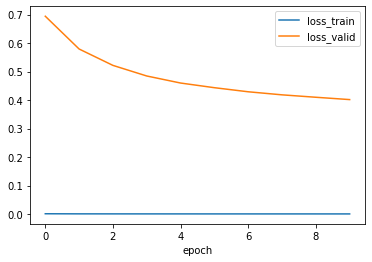

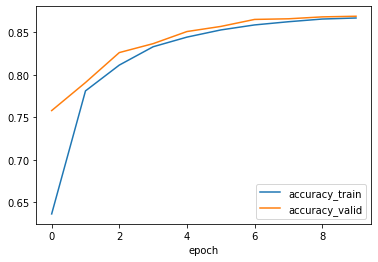

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

#
# Accuracy, Lossを求める計算をメインループに入れると、煩雑なので、
# クラスにまとめておく
#
class Measure():
  def __init__(self):
    self.loss_train_list = []
    self.loss_valid_list = []
    self.accuracy_train_list = []
    self.accuracy_valid_list = []

  def init_epoch(self):
    self.correct_train = 0
    self.total_train = 0
    self.correct_valid = 0
    self.total_valid = 0
    self.loss_train = 0.0
    self.loss_valid = 0.0

  def accuracy(self, inputs,outputs,labels):
    total = len(inputs)
    prediction = torch.argmax(outputs, dim=1)
    correct = torch.sum(prediction==labels.squeeze(1))
    return total, correct

  def record_train(self,inputs,outputs,labels,lossitem):
    self.loss_train += lossitem
    total, correct = self.accuracy(inputs,outputs,labels)
    self.total_train += total
    self.correct_train += correct

  def train(self):
    self.loss_train /= len(dataset_train)
    self.accuracy_train = self.correct_train / self.total_train

  def record_valid(self,inputs,outputs,labels, lossitem):
    self.loss_valid += lossitem
    total, correct = self.accuracy(inputs,outputs,labels)
    self.total_valid += total
    self.correct_valid += correct

  def valid(self):
    self.accuracy_valid = self.correct_valid / self.total_valid

  def record_epoch(self,epoch):
    print(f'epoch: {epoch + 1}, loss_train: {self.loss_train:.4f}, loss_valid: {self.loss_valid:.4f}, \
    accuracy_train: {self.accuracy_train:.2f}, accuracy_valid: {self.accuracy_valid:.2f}')
    self.loss_train_list.append(self.loss_train)
    self.loss_valid_list.append(self.loss_valid)
    self.accuracy_train_list.append(self.accuracy_train)
    self.accuracy_valid_list.append(self.accuracy_valid)

#
# 結果のプロット用の補助関数
#
def draw(numEpochs, loss_train_list, loss_valid_list, accuracy_train_list, accuracy_valid_list):
  plt.figure()
  plt.plot(range(numEpochs), loss_train_list, label='loss_train')
  plt.plot(range(numEpochs), loss_valid_list, label='loss_valid')
  plt.legend()
  plt.xlabel('epoch')
  plt.show()
  plt.figure()
  plt.plot(range(numEpochs), accuracy_train_list, label='accuracy_train')
  plt.plot(range(numEpochs), accuracy_valid_list, label='accuracy_valid')
  plt.legend()
  plt.xlabel('epoch')
  plt.show()

torch.manual_seed(0)
model = Net(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
numEpochs = 10
measure = Measure() #<---

for epoch in range(numEpochs):
  measure.init_epoch() #<---
  model.train()
  for batch_index, (inputs, labels) in enumerate(dataloader_train): # batch size is 1
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels.squeeze(1)) #labels=tensor([[a]]) shape=(1,1) -> labels.squeeze(dim=1)==tensor([a]), shape=(1)
    loss.backward()
    optimizer.step()
    measure.record_train(inputs,outputs,labels,loss.item()) #<---
  measure.train() #<---

  model.eval() 
  with torch.no_grad(): # batch size is len(dataset_valid)
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs,labels.squeeze(1)) #labels=tensor([[a],[b],...]) shape=(1334,1) -> labels.squeeze(dim=1)==tensor([a,b...]), shape=(1334)
    measure.record_valid(inputs,outputs,labels,loss_valid.item()) #<---
  measure.valid() #<---

  measure.record_epoch(epoch) #<---

draw(numEpochs, measure.loss_train_list, measure.loss_valid_list, measure.accuracy_train_list, measure.accuracy_valid_list) #<---


##課題76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

###解説
75のコードの最後に、以下を追加する。
 torch.save({'epoch': epoch, 
              'model_state_dict': model.state_dict(), 
              'optimizer_state_dict': optimizer.state_dict()}, 
              f'checkpoint{epoch + 1}.pt')


###解答例

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)
model = Net(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
numEpochs = 10

for epoch in range(numEpochs):
  model.train()
  for batch_index, (inputs, labels) in enumerate(dataloader_train): # batch size is 1
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels.squeeze(dim=0)) #labels=tensor([[a]]) shape=(1,1) -> labels.squeeze(dim=0)==tensor([a]), shape=(1)
    loss.backward()
    optimizer.step()
  model.eval() 
  with torch.no_grad(): # batch size is len(dataset_valid)
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
  #
  #エポックごとにモデルパラメータを保存
  #
  torch.save({'epoch': epoch, 
              'model_state_dict': model.state_dict(), 
              'optimizer_state_dict': optimizer.state_dict()}, 
              f'checkpoint{epoch + 1}.pt')
#
# 最後に保存したものを、試しにダンプ
# 長いJobの途中で中断して、再開するときなどに便利。
#
checkpoint = torch.load(f'checkpoint{epoch + 1}.pt')
print(checkpoint['epoch'])
model.load_state_dict(checkpoint['model_state_dict'])
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


##課題77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

###解説
ミニバッチのサイズによって、かかる時間がどういう影響を受けるかを見たい。
75などのコードは、DataLoaderの定義時にtrainは１、その他はデータセット全体のサイズにしていた。

73ないし75のコードから、trainingしているところを切り出して関数trainにする。

引数をバッチサイズとし、dataloader_trainを、そのサイズで定義しなおす。

そのあと、通常のトレーニングを行う。

速さを見るため、LossやAccuracyの関連コードは、いったん抜く。そのうえで、以下のコードを実行する。

for batch_size in [2 ** i for i in range(11)]:

..start = time.time()

..train(batch_size)

..end = time.time()

..print(batch_size, (end - start)/numEpochs)

###解答例

In [ ]:
#71,73前提
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

numEpochs = 10

#
# 73ないし75のコードから、trainingしているところを切り出して関数trainにする。
#
def train(train_batch_size):
  dataset_train = NewsDataset(x_train, y_train)
  #dataloader_trainを定義し、ミニバッチサイズを設定する。
  dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True)
  torch.manual_seed(1)

  model = Net(300, 4)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

  for epoch in range(numEpochs):
    for batch_index, (inputs, labels) in enumerate(dataloader_train): 
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.squeeze(1))
      loss.backward()
      optimizer.step()

for batch_size in [2 ** i for i in range(11)]:
  start = time.time()
  train(batch_size)
  end = time.time()
  print(batch_size, (end - start)/numEpochs)


##課題78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

###解説
77のコードを変更するが、CPUタイプをここでGPUに切り替える（VM・メモリのリセットが起きる）。そのため、カレントフォルダー設定、クラスNetの定義、trainに関するデータセット、データローダーの定義、をやり直す必要がある。

以下の三か所で、GPUで計算するための処理を追加。

冒頭で、
device = torch.device('cuda')

モデルのインスタンス化のところで
model = Net(300, 4).to(device)

データを取り出してモデルに送るところで、以下のように変更する。

for batch_index, (inputs, labels) in enumerate(dataloader_train): 

..inputs = inputs.to(device)

..labels = labels.to(device)


In [ ]:
!pwd
%cd /content/drive/My Drive/Colab Notebooks/NLP

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

class Net(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc = nn.Linear(input_size, output_size)
    nn.init.kaiming_normal_(self.fc.weight)

  def forward(self, x):
    x = self.fc(x)
    return x

class NewsDataset(Dataset):
  def __init__(self, x, y):  self.x, self.y = x, y
  def __len__(self):  return len(self.y)
  def __getitem__(self, idx):  return [self.x[idx], self.y[idx]]

x_train = torch.tensor(pd.read_csv('train.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
y_train = torch.tensor(pd.read_csv('train.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
dataset_train = NewsDataset(x_train, y_train)

device = torch.device('cuda') #<----------
numEpochs = 10

def train(train_batch_size):
  dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True)
  torch.manual_seed(0)

  model = Net(300, 4).to(device) #<----------
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
  numEpochs = 10

  for epoch in range(numEpochs):
    for batch_index, (inputs, labels) in enumerate(dataloader_train): 
      inputs = inputs.to(device) #<----------
      labels = labels.to(device) #<----------
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.squeeze(1))
      loss.backward()
      optimizer.step()

for batch_size in [2 ** i for i in range(11)]:
  start = time.time()
  train(batch_size)
  end = time.time()
  print(batch_size, (end - start)/numEpochs)

###解答例

##課題79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

###解説
以上やったコードをまとめ上げて、以下などを試してみてください。

クラスNetを変更し、単一全結合でなく、複数の全結合をつないでみる。

全結合の入出力ベクトル要素数は、いきなり300->４でなく、少しづつ数を減らすようにするといいです。

全結合の中間にBatchNormalizationを挟むといいです。

モデルパラメータの初期値を変えてみる。

Learning_rateを変更してみる。

Epoch数を変更してみる。

###解答例

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class NewsDataset(Dataset):
  def __init__(self, x, y):  self.x, self.y = x, y
  def __len__(self):  return len(self.y)
  def __getitem__(self, idx):  return [self.x[idx], self.y[idx]]

class Net(nn.Module):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, 64)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.fc2 = nn.Linear(64, 16)
    nn.init.kaiming_normal_(self.fc2.weight)
    self.bn = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(16, output_size)
    nn.init.kaiming_normal_(self.fc3.weight)
    self.bn2 = nn.BatchNorm1d(16)

  def forward(self, x):
    x = self.fc3(F.relu(self.bn2(self.fc2(F.relu(self.bn(self.fc1(x)))))))
    return x

class Measure():
  def __init__(self):
    self.loss_train_list = []
    self.loss_valid_list = []
    self.accuracy_train_list = []
    self.accuracy_valid_list = []

  def init_epoch(self):
    self.correct_train = 0
    self.total_train = 0
    self.correct_valid = 0
    self.total_valid = 0
    self.loss_train = 0.0
    self.loss_valid = 0.0

  def accuracy(self, inputs,outputs,labels):
    total = len(inputs)
    prediction = torch.argmax(outputs, dim=1)
    correct = torch.sum(prediction==labels.squeeze(1))
    return total, correct

  def record_train(self,inputs,outputs,labels,lossitem):
    self.loss_train += lossitem
    total, correct = self.accuracy(inputs,outputs,labels)
    self.total_train += total
    self.correct_train += correct

  def train(self):
    self.loss_train /= len(dataset_train)
    self.accuracy_train = self.correct_train / self.total_train

  def record_valid(self,inputs,outputs,labels, lossitem):
    self.loss_valid += lossitem
    total, correct = self.accuracy(inputs,outputs,labels)
    self.total_valid += total
    self.correct_valid += correct

  def valid(self):
    self.loss_valid /= len(dataset_valid)
    self.accuracy_valid = self.correct_valid / self.total_valid

  def record_epoch(self, epoch):
    print(f'epoch: {epoch + 1}, loss_train: {self.loss_train:.4f}, loss_valid: {self.loss_valid:.4f}, \
    accuracy_train: {self.accuracy_train:.2f}, accuracy_valid: {self.accuracy_valid:.2f}')
    self.loss_train_list.append(self.loss_train)
    self.loss_valid_list.append(self.loss_valid)
    self.accuracy_train_list.append(self.accuracy_train)
    self.accuracy_valid_list.append(self.accuracy_valid)

def draw(numEpochs, loss_train_list, loss_valid_list, accuracy_train_list, accuracy_valid_list ):
  plt.figure()
  plt.plot(range(numEpochs), loss_train_list, label='loss_train')
  plt.plot(range(numEpochs), loss_valid_list, label='loss_valid')
  plt.legend()
  plt.xlabel('epoch')
  plt.show()
  plt.figure()
  plt.plot(range(numEpochs), accuracy_train_list, label='accuracy_train')
  plt.plot(range(numEpochs), accuracy_valid_list, label='accuracy_valid')
  plt.legend()
  plt.xlabel('epoch')
  plt.show()

torch.manual_seed(1)
device = torch.device('cuda')
train_batch_size = 1024

numEpochs = 200
learning_rate = 0.01

x_train = torch.tensor(pd.read_csv('train.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
y_train = torch.tensor(pd.read_csv('train.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
dataset_train = NewsDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=train_batch_size, shuffle=True)
x_valid = torch.tensor(pd.read_csv('valid.vector.txt', sep='\t', header=None).to_numpy(), dtype=torch.float)
y_valid = torch.tensor(pd.read_csv('valid.label.txt', sep='\t', header=None).to_numpy(), dtype=torch.long)
dataset_valid = NewsDataset(x_valid, y_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

model = Net(300, 4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
measure = Measure()

for epoch in range(numEpochs):
  measure.init_epoch()

  model.train()
  for batch_index, (inputs, labels) in enumerate(dataloader_train): 
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels.squeeze(1)) #labels=tensor([[a]]) shape=(1,1) -> labels.squeeze(dim=1)==tensor([a]), shape=(1)
    loss.backward()
    optimizer.step()
    measure.record_train(inputs,outputs,labels, loss.item())
  measure.train()
  
  model.eval() 
  with torch.no_grad(): # batch size is len(dataset_valid)
    inputs, labels = next(iter(dataloader_valid))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels.squeeze(1))  #labels=tensor([[a],[b],...]) shape=(1334,1) -> labels.squeeze(dim=1)==tensor([a,b...]), shape=(1334)
    measure.record_valid(inputs,outputs,labels, loss_valid.item())
  measure.valid()

  measure.record_epoch(epoch)
  
draw(numEpochs, measure.loss_train_list, measure.loss_valid_list, measure.accuracy_train_list, measure.accuracy_valid_list)
